# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [4]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

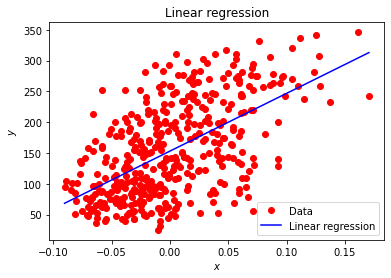

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [6]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [9]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

$Bias(\hat{θ}_{m}) = E[\hat{θ}_{m}] − θ$

$Var(\hat{θ}_{m}) = E[(\hat{θ}_{m} − E[\hat{θ}_{m}])^{2}]$

$                 = E(\hat{θ}_{m}^{2} -2\hat{θ}_{m}E[\hat{θ}_{m}] + E[\hat{θ}_{m}]^{2})$

$ = E(\hat{θ}_{m}^{2}) - E[2[\hat{θ}_{m}]E[\hat{θ}_{m}]] + E[E[\hat{θ}_{m}]^{2}]$

$ = E(\hat{θ}_{m}^{2}) - 2E[\hat{θ}_{m}]E[\hat{θ}_{m}] + E[\hat{θ}_{m}]^{2}$

$ = E(\hat{θ}_{m}^{2}) - 2E[\hat{θ}_{m}]^{2} + E[\hat{θ}_{m}]^{2}$

$ = E(\hat{θ}_{m}^{2}) - E[\hat{θ}_{m}]^{2}$



$MSE = E[(\hat{θ}_{m}− θ)^{2}]$

$    = E[\hat{θ}_{m}^{2} - 2\hat{θ}_{m}θ + θ^{2}]$

$    = E(\hat{θ}_{m}^{2}) - E(2\hat{θ}_{m}θ) + E(θ^{2})$

$    = E(\hat{θ}_{m}^{2}) - 2θE(\hat{θ}_{m}) + (θ^{2})$

$    = E(\hat{θ}_{m}^{2}) - 2θE(\hat{θ}_{m}) + (θ^{2})$

$    = E(\hat{θ}_{m}^{2}) - E[\hat{θ}_{m}]^{2} + E[\hat{θ}_{m}]^{2} - 2θE(\hat{θ}_{m}) + (θ^{2})$

$    = Var(\hat{θ}_{m}) + E[\hat{θ}_{m}]^{2} - 2θE(\hat{θ}_{m}) + (θ^{2})$

$    = Var(\hat{θ}_{m}) + Bias(\hat{θ}_{m})^{2}$

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

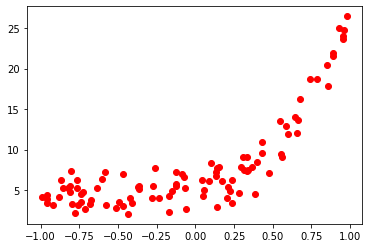

In [10]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order.

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>

<p>Answer: The models with a degree less than 2 have a high bias. This is seen in the validation curve where the MSE is relatively high of both the training and validation set. Models using a polynomial degree that's 13 or higher show signs of overfitting. This is also seen in the validation curve and visualized in the plots with the data and polynomial regression. These models have a high variance, since the error on the training data is low but the model does not generalize on new data. Meaning that the error on the validation set is high.<p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, validation_curve, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# add an extra dimension to the array
X = X[:, np.newaxis]
y = y[:, np.newaxis]

#split training and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    1.8s finished
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])
Independent test set MSE: 1.8544319867436365
Cross-validation MSE: 2.504929645381044


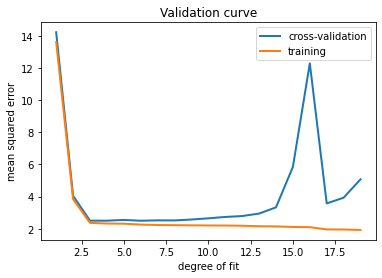

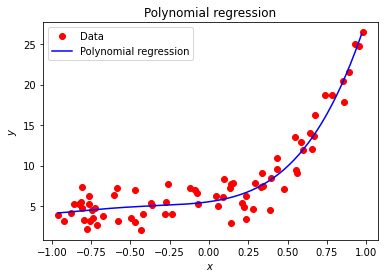

In [12]:
# the range of polynominal degrees. 1-20
degrees = np.arange(1, 20)

# A parameter library with settings
param_grid = {'polynomialfeatures__degree': degrees,
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

# Function to make a pipeline for polynomial regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

# Setup GridSearchCV
poly_grid = GridSearchCV(PolynomialRegression(), param_grid, 
                         cv=10, 
                         scoring='neg_mean_squared_error', 
                         verbose=1) 

# fit with all degrees
poly_grid = poly_grid.fit(X_train, y_train)

# Select model with best degree
model = poly_grid.best_estimator_
print(model)

# find train scores and validation scores
train_scores, validation_scores = validation_curve(
    model, X, y,
    param_name='polynomialfeatures__degree',
    param_range=degrees, cv = 10, scoring = 'neg_mean_squared_error')

# predicts the test data with the best found degree
prediction = model.predict(X_test)

# error calculation using mean squared error
mse = mean_squared_error(y_test, prediction)
print("Independent test set MSE: "+ str(mse))

# evaluates score by cross-validation
scores = cross_val_score(model, X, y,
                scoring="neg_mean_squared_error", cv=10)
print('Cross-validation MSE: ' + str(-scores.mean()))

#plot figure cross validation
plt.figure()
plt.plot(degrees, -validation_scores.mean(axis=1), lw=2,
         label='cross-validation')
plt.plot(degrees, -train_scores.mean(axis=1), lw=2, label='training')

plt.legend(loc='best')
plt.xlabel('degree of fit')
plt.ylabel('mean squared error')
plt.title('Validation curve')

#plot figure polynomial regression model on test data
plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.arange(np.min(X_train, 0), np.max(X_train, 0), 0.01)
plt.plot(X_edge, model.predict(X_edge[:,np.newaxis]), 'b-')
plt.legend(('Data', 'Polynomial regression'))
plt.title('Polynomial regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

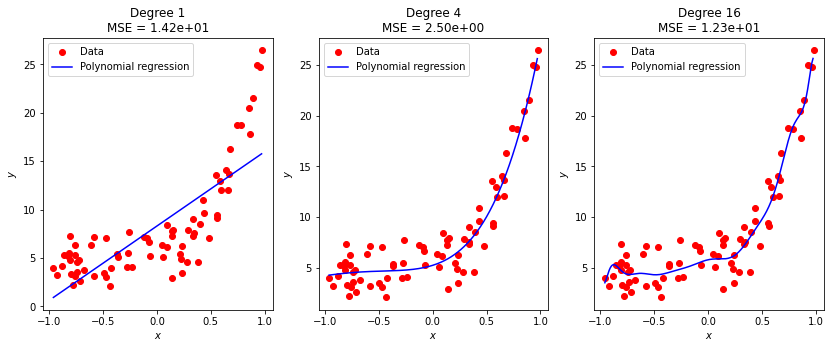

In [172]:
# selected degrees to plot
degrees = [1, 4, 16]

# for loop for plotting the degrees
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    
    # fitting the model with the selected degree
    model = PolynomialRegression(degree=degrees[i])
    model.fit(X, y) 
    
    # Evaluating the score of the selected model
    scores = cross_val_score(model, X, y,
                             scoring="neg_mean_squared_error", cv=10) 
    
    # plotting the results
    plt.plot(X_train, y_train, 'r.', markersize=12)
    X_edge = np.arange(np.min(X_train, 0), np.max(X_train, 0), 0.01)
    plt.plot(X_edge, model.predict(X_edge[:,np.newaxis]), 'b-')
    plt.legend(('Data', 'Polynomial regression'))
    plt.title('Polynomial regression')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title("Degree {}\nMSE = {:.2e}".format(
        degrees[i], -scores.mean()))
plt.show()

#### Diabetes Dataset

In [190]:
# set up diabetes dataset
X = diabetes.data
y = diabetes.target[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])
Independent test set MSE: 1.8544319867436365
Cross-validation MSE: 2.504929645381044
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.3s finished


Text(0.5, 1.0, 'Validation curve')

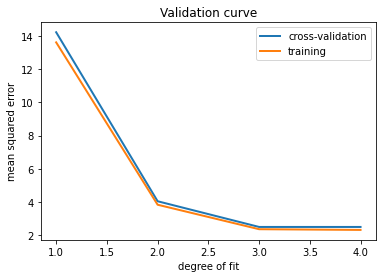

In [13]:
# the range of polynominal degrees. 1-5
degrees = np.arange(1, 5)

# A parameter library with settings
param_grid = {'polynomialfeatures__degree': degrees,
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

# Function to make a pipeline for polynomial regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

# Setup GridSearchCV
poly_grid = GridSearchCV(PolynomialRegression(), param_grid, 
                         cv=10, 
                         scoring='neg_mean_squared_error', 
                         verbose=1) 
# fit with all degrees
poly_grid = poly_grid.fit(X_train, y_train)

# Select model with best degree
model = poly_grid.best_estimator_
print(model)

# find train scores and validation scores
train_scores, validation_scores = validation_curve(
    model, X, y,
    param_name='polynomialfeatures__degree',
    param_range=degrees, cv = 10, scoring = 'neg_mean_squared_error')


# predicts the test data with the best found degree
prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
print("Independent test set MSE: "+ str(mse))

# error calculation using mean squared error
scores = cross_val_score(model, X, y,
                scoring="neg_mean_squared_error", cv=10)
print('Cross-validation MSE: ' + str(-scores.mean()))

# plot validation curve.
plt.figure()
plt.plot(degrees, -validation_scores.mean(axis=1), lw=2,
         label='cross-validation')
plt.plot(degrees, -train_scores.mean(axis=1), lw=2, label='training')

plt.legend(loc='best')
plt.xlabel('degree of fit')
plt.ylabel('mean squared error')
plt.title('Validation curve')

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, this time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

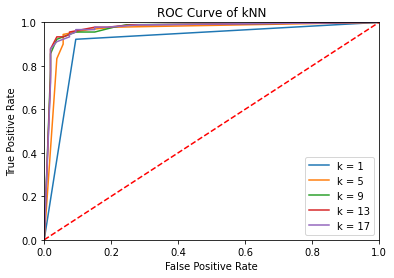

In [14]:
from sklearn.metrics import roc_curve

# load breast cancer data
X = breast_cancer.data
y = breast_cancer.target

# divide data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)


n_neighbors = np.arange(1, 20, 4)
# initialize a k-NN classifier
for i in range(len(n_neighbors)):
    model = neighbors.KNeighborsClassifier(n_neighbors[i])
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, prediction[:, 1])
    plt.plot(fpr, tpr, label = 'k = %0.0f' % n_neighbors[i])

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


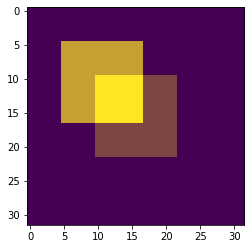

In [212]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

$F_{1} = 2*\frac{precision * recall}{precision + recall}$

$precision = \frac{TP}{TP+FP}$

$recall = \frac{TP}{TP+FN}$

$F_{1} = 2*\frac{\frac{TP}{TP+FP} * \frac{TP}{TP+FN}}{\frac{TP}{TP+FP} + \frac{TP}{TP+FN}} = 2*\frac{TP * \frac{TP}{TP+FN}}{TP + \frac{TP(TP+FP)}{TP+FN}} = 2*\frac{TP * TP}{TP(TP+FN) + TP(TP+FP)} $

$= 2*\frac{TP}{TP+FN + TP+FP} = \frac{2TP}{2TP+FN+FP}$



$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|} = \frac{2TP}{TP+FN + TP+FP} = \frac{2TP}{2TP+FN+FP}$